# Exercise 3: Neural networks in PyTorch

In this exercise you’ll implement small neural-network building blocks from scratch and use them to train a simple classifier.

You’ll cover:
- **Basic layers**: Linear, Embedding, Dropout
- **Normalization**: LayerNorm and RMSNorm
- **MLPs + residual**: composing layers into deeper networks
- **Classification**: generating a learnable dataset, implementing cross-entropy from logits, and writing a minimal training loop

As before: fill in all `TODO`s without changing function names or signatures.
Use small sanity checks and compare to PyTorch reference implementations when useful.

In [1]:
from __future__ import annotations

import torch
from torch import nn

## Basic layers

In this section you’ll implement a few core layers that appear everywhere:

### `Linear`
A fully-connected layer that follows nn.Linear conventions:  
`y = x @ Wᵀ + b`

Important details:
- Parameters should be registered as `nn.Parameter`
- Store weight as (out_features, in_features) like nn.Linear.
- The forward pass should support leading batch dimensions: `x` can be shape `(..., in_features)`

### `Embedding`
An embedding table maps integer ids to vectors:
- input: token ids `idx` of shape `(...,)`
- output: vectors of shape `(..., embedding_dim)`

This is essentially a learnable lookup table.

### `Dropout`
Dropout randomly zeroes activations during training to reduce overfitting.
Implementation details:
- Only active in `model.train()` mode
- In training: drop with probability `p` and scale the kept values by `1/(1-p)` so the expected value stays the same
- In eval: return the input unchanged

## Instructions
- Do not use PyTorch reference modules for the parts you implement (e.g. don’t call nn.Linear inside your Linear).
- You may use standard tensor ops that you learned before (matmul, sum, mean, rsqrt, indexing, etc.).
- Use a parameter initialization method of your choice. We recommend something like Xavier-uniform.


In [2]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.bias = None

        # Xavier uniform initialization
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., in_features)
        return: (..., out_features)
        """
        out = torch.matmul(x, self.weight.t())
        if self.bias is not None:
            out = out + self.bias
        return out

In [3]:
class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.weight = nn.Parameter(torch.empty(num_embeddings, embedding_dim))

        # Xavier uniform initialization
        nn.init.xavier_uniform_(self.weight)

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        """
        idx: (...,) int64
        return: (..., embedding_dim)
        """
        return self.weight[idx]


In [4]:
class Dropout(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        In train mode: drop with prob p and scale by 1/(1-p).
        In eval mode: return x unchanged.
        """
        if self.training:
            mask = (torch.rand_like(x) > self.p).float()
            return mask * x / (1 - self.p)
        else:
            return x



In [5]:
#testall
if __name__ == "__main__":
    # Example usage of Linear
    linear = Linear(in_features=4, out_features=2)
    x = torch.randn(3, 4)  # batch of 3 samples, each with 4 features
    print("Input:", x)

    output = linear(x)
    print("Linear output:", output)

    # Example usage of Embedding
    embedding = Embedding(num_embeddings=10, embedding_dim=5)
    idx = torch.tensor([0, 1, 2])  # indices to look up
    embedded = embedding(idx)
    print("Embedding output:", embedded)

    # Example usage of Dropout
    dropout = Dropout(p=0.5)
    dropout.train()  # set to training mode
    dropped_out = dropout(x)
    print("Dropout output (training):", dropped_out)

    dropout.eval()  # set to evaluation mode
    dropped_out_eval = dropout(x)
    print("Dropout output (evaluation):", dropped_out_eval)

Input: tensor([[ 0.1766, -0.2139, -0.7506, -0.5641],
        [ 0.0471,  2.3076, -0.1107, -0.8885],
        [-1.1044, -1.5089, -1.6253,  0.9545]])
Linear output: tensor([[-0.8143, -0.6567],
        [ 1.2080, -1.2042],
        [-2.0410,  0.8080]], grad_fn=<AddBackward0>)
Embedding output: tensor([[ 0.4530, -0.2404, -0.2331, -0.5033,  0.3498],
        [-0.5249,  0.3318, -0.3103,  0.5169,  0.5012],
        [ 0.3850, -0.4507, -0.4005,  0.3479,  0.4099]],
       grad_fn=<IndexBackward0>)
Dropout output (training): tensor([[ 0.0000, -0.4277, -0.0000, -1.1283],
        [ 0.0943,  4.6151, -0.0000, -1.7770],
        [-0.0000, -3.0178, -3.2505,  1.9090]])
Dropout output (evaluation): tensor([[ 0.1766, -0.2139, -0.7506, -0.5641],
        [ 0.0471,  2.3076, -0.1107, -0.8885],
        [-1.1044, -1.5089, -1.6253,  0.9545]])


## Normalization

Normalization layers help stabilize training by controlling activation statistics.

### LayerNorm
LayerNorm normalizes each example across its **feature dimension** (the last dimension):

- compute mean and variance over the last dimension
- normalize: `(x - mean) / sqrt(var + eps)`
- apply learnable per-feature scale and shift (`weight`, `bias`)

**In this exercise, assume `elementwise_affine=True` (always include `weight` and `bias`).**  
`weight` and `bias` each have shape `(D,)`.

LayerNorm is widely used in transformers because it does not depend on batch statistics.

### RMSNorm
RMSNorm is similar to LayerNorm but normalizes using only the root-mean-square:
- `x / sqrt(mean(x^2) + eps)` over the last dimension
- usually includes a learnable scale (`weight`)
- no mean subtraction

RMSNorm is popular in modern LLMs because it's faster.


In [6]:
class LayerNorm(nn.Module):
    def __init__(
        self, normalized_shape: int, eps: float = 1e-5, elementwise_affine: bool = True
    ):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine

        # According to the instructions, we assume elementwise_affine=True
        # Always include weight and bias
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize over the last dimension.
        x: (..., D)
        """
        # Compute mean and variance over the last dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        # Normalize
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)

        # Apply learnable scale and shift (always included per instructions)
        x_normalized = x_normalized * self.weight + self.bias

        return x_normalized

#test LayerNorm
if __name__ == "__main__":
    # Example usage of LayerNorm
    layer_norm = LayerNorm(normalized_shape=4)
    x = torch.randn(2, 3, 4)  # batch of 2 samples, each with 3x4 features
    print("Input:", x)
    print("Mean before LayerNorm:", x.mean(dim=-1))
    print("Variance before LayerNorm:", x.var(dim=-1, unbiased=False))
    print()

    output = layer_norm(x)
    print("LayerNorm output:", output)
    print("Mean after LayerNorm:", output.mean(dim=-1))
    print("Variance after LayerNorm:", output.var(dim=-1, unbiased=False))


Input: tensor([[[-4.7501e-01, -4.6014e-01, -1.1408e+00,  2.9229e-01],
         [ 6.9341e-01,  1.4006e+00,  7.7336e-01,  1.2807e-01],
         [ 5.4652e-01, -2.3174e+00, -3.7514e-01, -5.6031e-01]],

        [[ 6.1431e-02, -1.4739e-04, -1.9731e-01,  1.0203e+00],
         [ 5.4007e-01,  1.1471e+00,  1.8805e+00, -4.7870e-01],
         [-3.0010e-01, -9.0918e-01, -5.1774e-01,  1.9317e+00]]])
Mean before LayerNorm: tensor([[-0.4459,  0.7489, -0.6766],
        [ 0.2211,  0.7723,  0.0512]])
Variance before LayerNorm: tensor([[0.2572, 0.2035, 1.0732],
        [0.2221, 0.7469, 1.2265]])

LayerNorm output: tensor([[[-0.0573, -0.0280, -1.3701,  1.4555],
         [-0.1229,  1.4449,  0.0543, -1.3763],
         [ 1.1807, -1.5839,  0.2910,  0.1122]],

        [[-0.3388, -0.4694, -0.8878,  1.6960],
         [-0.2687,  0.4338,  1.2824, -1.4475],
         [-0.3172, -0.8672, -0.5137,  1.6981]]], grad_fn=<AddBackward0>)
Mean after LayerNorm: tensor([[2.9802e-08, 5.9605e-08, 2.0489e-08],
        [0.0000e+00,

In [7]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-8):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        RMSNorm: x / sqrt(mean(x^2) + eps) * weight
        over the last dimension.
        """
        # Compute root mean square over the last dimension
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)

        # Normalize by RMS
        x_normalized = x / rms

        # Apply learnable scale
        x_normalized = x_normalized * self.weight

        return x_normalized

#test RMSNorm
if __name__ == "__main__":
    # Example usage of RMSNorm
    rms_norm = RMSNorm(normalized_shape=4)
    x = torch.randn(2, 3, 4)  # batch of 2 samples, each with 3x4 features
    print("Input:", x)
    print("RMS before RMSNorm:", torch.sqrt(torch.mean(x ** 2, dim=-1)))
    print()
    output = rms_norm(x)
    print("RMSNorm output:", output)
    print("RMS after RMSNorm:", torch.sqrt(torch.mean(output ** 2, dim=-1)))


Input: tensor([[[-0.6371,  0.1379,  1.4439,  0.8776],
         [ 0.8170,  0.0691, -0.9259, -0.3245],
         [ 1.9205,  0.7236,  0.9049, -0.0573]],

        [[ 0.3969, -0.3353,  0.1397, -0.5221],
         [ 0.5622,  0.8863,  0.9038,  0.0043],
         [ 0.2796, -0.6831, -2.4093, -0.7206]]])
RMS before RMSNorm: tensor([[0.9055, 0.6393, 1.1218],
        [0.3749, 0.6926, 1.3104]])

RMSNorm output: tensor([[[-0.7035,  0.1523,  1.5946,  0.9691],
         [ 1.2780,  0.1080, -1.4483, -0.5075],
         [ 1.7119,  0.6450,  0.8066, -0.0511]],

        [[ 1.0588, -0.8944,  0.3727, -1.3929],
         [ 0.8118,  1.2798,  1.3051,  0.0062],
         [ 0.2134, -0.5213, -1.8386, -0.5499]]], grad_fn=<MulBackward0>)
RMS after RMSNorm: tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]], grad_fn=<SqrtBackward0>)


In [8]:
#compare speedup of rmsnorm wrt layernorm
if __name__ == "__main__":
    import time

    # Create large random input
    x = torch.randn(1000, 1000)

    # Initialize LayerNorm and RMSNorm
    layer_norm = LayerNorm(normalized_shape=1000)
    rms_norm = RMSNorm(normalized_shape=1000)

    # Time LayerNorm
    start_time = time.time()
    for _ in range(100):
        _ = layer_norm(x)
    layer_norm_time = time.time() - start_time
    print(f"LayerNorm time for 100 iterations: {layer_norm_time:.4f} seconds")

    # Time RMSNorm
    start_time = time.time()
    for _ in range(100):
        _ = rms_norm(x)
    rms_norm_time = time.time() - start_time
    print(f"RMSNorm time for 100 iterations: {rms_norm_time:.4f} seconds")

    # Calculate speedup
    speedup = layer_norm_time / rms_norm_time if rms_norm_time > 0 else float('inf')
    print(f"Speedup of RMSNorm over LayerNorm: {speedup:.2f}x")

LayerNorm time for 100 iterations: 0.4881 seconds
RMSNorm time for 100 iterations: 0.0976 seconds
Speedup of RMSNorm over LayerNorm: 5.00x


It does actually go faster!

## MLPs and residual networks

Now you’ll build larger networks by composing layers.

### MLP
An MLP is a stack of `depth` Linear layers with non-linear activations (use GELU) in between.
In this exercise you’ll support:
- configurable depth
- a hidden dimension
- optional LayerNorm between layers (a common stabilization trick)

A key skill is building networks using `nn.ModuleList` / `nn.Sequential` while keeping shapes consistent.

### Transformer-style FeedForward (FFN)
A transformer block contains a position-wise feedforward network:
- `D -> 4D -> D` (by default)
- activation is typically **GELU**

This is essentially an MLP applied independently at each token position.

### Residual wrapper
Residual connections are the simplest form of “skip connection”:
- output is `x + fn(x)`

They improve gradient flow and allow training deeper networks more reliably.

In [9]:
class MLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        depth: int,
        use_layernorm: bool = False,
    ):
        super().__init__()
        # Build a stack of Linear layers with GELU activations
        # depth controls the number of hidden layers
        layers = []

        # First layer: in_dim -> hidden_dim
        layers.append(Linear(in_dim, hidden_dim))
        if use_layernorm:
            layers.append(LayerNorm(hidden_dim))
        layers.append(nn.GELU())

        # Hidden layers: hidden_dim -> hidden_dim
        for _ in range(depth - 1):
            layers.append(Linear(hidden_dim, hidden_dim))
            if use_layernorm:
                layers.append(LayerNorm(hidden_dim))
            layers.append(nn.GELU())

        # Final layer: hidden_dim -> out_dim (no activation after)
        layers.append(nn.Linear(hidden_dim, out_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [10]:
class FeedForward(nn.Module):
    """
    Transformer-style FFN: D -> 4D -> D (default)
    """

    def __init__(self, d_model: int, d_ff: int | None = None):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.fc1 = Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.fc2 = Linear(d_ff, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [11]:
class Residual(nn.Module):
    def __init__(self, fn: nn.Module):
        super().__init__()
        self.fn = fn

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        return x + self.fn(x, *args, **kwargs)

## Classification problem

In this section you’ll put everything together in a minimal MNIST classification experiment.

You will:
1) download and load the MNIST dataset
2) implement cross-entropy from logits (stable, using log-softmax)
3) build a simple MLP-based classifier (flatten MNIST images first)
4) write a minimal training loop
5) report train loss curve and final accuracy

The goal here is not to reach state-of-the-art accuracy, but to understand the full pipeline:
data → model → logits → loss → gradients → parameter update.

### Model notes
- We want you to combine the MLP we implemented above with the classification head we define below into one model 

### MNIST notes
- MNIST images are `28×28` grayscale.
- After `ToTensor()`, each image has shape `(1, 28, 28)` and values in `[0, 1]`.
- For an MLP classifier, we flatten to a vector of length `784`.

## Deliverables
- Include a plot of your train loss curve in the video submission as well as a final accuracy. 
- **NOTE** Here we don't grade on model performance but we expect you to achieve at least 70% accuracy to confirm a correct model implementation.

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
transform = transforms.ToTensor()  # -> float32 in [0,1], shape (1, 28, 28)

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [14]:
def cross_entropy_from_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
) -> torch.Tensor:
    """
    Compute mean cross-entropy loss from logits.

    logits: (B, C)
    targets: (B,) int64

    Requirements:
    - Use log-softmax for stability (do not use torch.nn.CrossEntropyLoss, we check this in the autograder).
    """
    # Apply log-softmax to logits for numerical stability
    log_probs = torch.nn.functional.log_softmax(logits, dim=1)

    # Gather the log probabilities corresponding to the target classes
    # targets has shape (B,), we need to index into log_probs at dimension 1
    batch_size = logits.shape[0]
    target_log_probs = log_probs[torch.arange(batch_size), targets]

    # Cross-entropy is the negative log likelihood
    # Return the mean over the batch
    return -target_log_probs.mean()

#test cross_entropy_from_logits
if __name__ == "__main__":
    # Create dummy logits and targets
    batch_size = 4
    num_classes = 3
    logits = torch.tensor([[1.0, 2.0, 3.0],
                           [1.0, 3.0, 2.0],
                           [3.0, 1.0, 2.0],
                           [2.0, 1.0, 3.0]])  # shape (4, 3)
    targets = torch.tensor([2, 1, 0, 2])  # shape (4,)

    loss = cross_entropy_from_logits(logits, targets)
    print("Cross-entropy loss:", loss.item())

Cross-entropy loss: 0.40760600566864014


In [15]:
class ClassificationHead(nn.Module):
    def __init__(self, d_in: int, num_classes: int):
        super().__init__()
        # Simple linear projection from feature dimension to class logits
        self.proj = Linear(d_in, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., d_in)
        return: (..., num_classes) logits
        """
        return self.proj(x)

# Quick check for ClassificationHead
if __name__ == "__main__":
    head = ClassificationHead(d_in=16, num_classes=10)
    x = torch.randn(4, 16)
    logits = head(x)
    print(f"Input shape: {x.shape}")
    print(f"Logits shape: {logits.shape}")

Input shape: torch.Size([4, 16])
Logits shape: torch.Size([4, 10])


In [ ]:
#import numpy as np
def accuracy(loader, model):
    """
    Calculate accuracy of the model on the given data loader.

    Args:
        loader: DataLoader containing the dataset
        model: The model to evaluate

    Returns:
        float: Accuracy as a fraction between 0 and 1
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            # Ensure images are torch tensors (not PIL Images)
            if not isinstance(images, torch.Tensor):
                # Convert to tensor if needed
                images = torch.tensor(images, dtype=torch.float32)

            # Forward pass
            logits = model(images)

            # Get predictions (class with highest logit)
            predictions = torch.argmax(logits, dim=1)

            # Count correct predictions
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total if total > 0 else 0.0

#TEST WITH A DUMMY MODEL
if __name__ == "__main__":
    class DummyModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.fc = Linear(28*28, 10)

        def forward(self, x):
            x = self.flatten(x)
            return self.fc(x)

    dummy_model = DummyModel()
    acc = accuracy(test_loader, dummy_model)
    print(f"Dummy model accuracy: {acc:.4f}")

Dummy model accuracy: 0.1337


In [20]:
def train_classifier(
    model: nn.Module,
    train_data_loader: DataLoader,
    test_data_loader: DataLoader,
    lr: float,
    epochs: int,
    seed: int = 0,
) -> list[float]:
    """
    Minimal training loop for MNIST classification.

    Steps:
    - define optimizer
    - for each epoch:
        - sample minibatches
        - forward -> cross-entropy -> backward -> optimizer step
      - compute test accuracy at the end of each epoch
    - return list of training losses (one per update step)

    Requirements:
    - call model.train() during training and model.eval() during evaluation
    - do not use torch.nn.CrossEntropyLoss (use your cross_entropy_from_logits)
    """
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    for epoch in range(epochs):
        model.train()
        for images, labels in train_data_loader:
            images = images.to(model.parameters().__next__().device)
            labels = labels.to(model.parameters().__next__().device)

            # Forward pass
            logits = model(images)

            # Compute loss
            loss = cross_entropy_from_logits(logits, labels)
            train_losses.append(loss.item())

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on test set at the end of each epoch
        acc = accuracy(test_data_loader, model)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}")
    return train_losses




Epoch 1/5, Loss: 0.1157, Test Accuracy: 0.9682
Epoch 2/5, Loss: 0.0443, Test Accuracy: 0.9730
Epoch 3/5, Loss: 0.0621, Test Accuracy: 0.9776
Epoch 4/5, Loss: 0.0011, Test Accuracy: 0.9779
Epoch 5/5, Loss: 0.0006, Test Accuracy: 0.9768


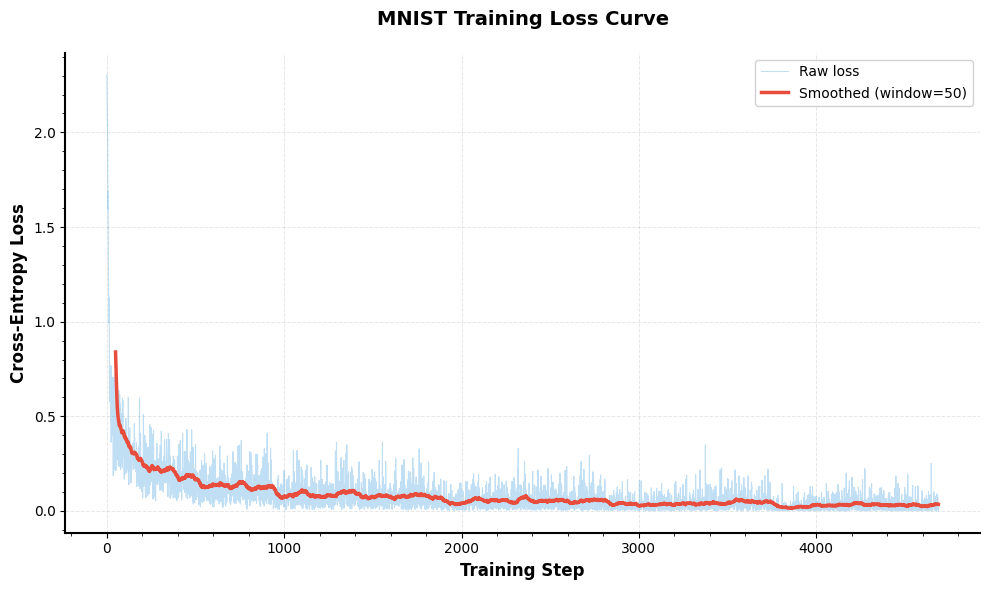

Final test accuracy: 0.9768


In [23]:
#import matplotlib.pyplot as plt
#import numpy as np


class MNISTMLPClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 256, depth: int = 2):
        super().__init__()
        self.flatten = nn.Flatten()
        # MLP: 784 -> hidden_dim -> ... -> 128
        self.mlp = MLP(
            in_dim=28 * 28,
            hidden_dim=hidden_dim,
            out_dim=128,
            depth=depth,
            use_layernorm=False,
        )
        # Classification head: 128 -> 10 logits
        self.head = ClassificationHead(d_in=128, num_classes=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.mlp(x)
        return self.head(x)


if __name__ == "__main__":
    # Set seed for reproducibility
    torch.manual_seed(0)

    # Build model
    model = MNISTMLPClassifier(hidden_dim=256, depth=2)

    # Train classifier
    train_losses = train_classifier(
        model,
        train_data_loader=train_loader,
        test_data_loader=test_loader,
        lr=1e-3,
        epochs=5,
    )

    # Plot learning curve (training loss per update step) with advanced styling
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

    # Plot raw losses with transparency
    steps = np.arange(len(train_losses))
    ax.plot(steps, train_losses, alpha=0.3, color='#3498db', linewidth=0.8, label='Raw loss')

    # Add smoothed curve using moving average
    window_size = min(50, len(train_losses) // 10)
    if window_size > 1:
        smoothed_losses = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        smoothed_steps = steps[window_size-1:]
        ax.plot(smoothed_steps, smoothed_losses, color='#e74c3c', linewidth=2.5,
                label=f'Smoothed (window={window_size})', zorder=5)

    # Styling
    ax.set_xlabel("Training Step", fontsize=12, fontweight='bold')
    ax.set_ylabel("Cross-Entropy Loss", fontsize=12, fontweight='bold')
    ax.set_title("MNIST Training Loss Curve", fontsize=14, fontweight='bold', pad=20)

    # Grid with custom styling
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
    ax.set_axisbelow(True)

    # Legend
    ax.legend(loc='upper right', framealpha=0.9, fontsize=10)

    # Spine styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Add minor ticks
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

    # Final accuracy printout
    final_acc = accuracy(test_loader, model)
    print(f"Final test accuracy: {final_acc:.4f}")
